In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/Kannada-MNIST/Dig-MNIST.csv
/kaggle/input/Kannada-MNIST/train.csv
/kaggle/input/Kannada-MNIST/sample_submission.csv
/kaggle/input/Kannada-MNIST/test.csv


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import torchvision

import matplotlib.pyplot as plt

In [3]:
train = pd.read_csv('../input/Kannada-MNIST/train.csv').to_numpy()
test = pd.read_csv('../input/Kannada-MNIST/test.csv').to_numpy()

X_train, y_train = train[:, 1:], train[:, 0]
X_test, X_id = test[:, 1:], test[:, 0]

X_train, y_train = torch.tensor(X_train).to(torch.float), torch.tensor(y_train)
X_test, X_id = torch.tensor(X_test).to(torch.float), torch.tensor(X_id)

In [4]:
dset_test = data.TensorDataset(X_test.reshape(-1, 1, 28, 28), X_id)
dset_train = data.TensorDataset(X_train.reshape(-1, 1, 28, 28), y_train)

factor = 0.9
train_len = int(len(dset_train) * factor)
valid_len = len(dset_train)  - train_len

dset_train, dset_valid = data.random_split(dset_train, [train_len, valid_len])


In [5]:
len(dset_train), len(dset_valid)

(54000, 6000)

In [6]:
batch_size = 16

dloader_train = data.DataLoader(dset_train, batch_size=batch_size, shuffle=True)
dloader_valid = data.DataLoader(dset_valid, batch_size=batch_size, shuffle=True)
dloader_test = data.DataLoader(dset_test, batch_size=len(dset_train), shuffle=False)

In [7]:
len(dloader_train), len(dloader_valid)

(3375, 375)

In [8]:
x, y = next(iter(dloader_train))

tensor([2, 5, 8, 1, 4, 0, 3, 9, 0, 6, 0, 1, 9, 0, 8, 4])


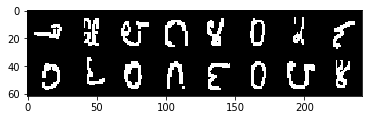

In [9]:
plt.imshow(torchvision.utils.make_grid(x).numpy().transpose(1, 2, 0))
print(y)

In [10]:
class Model(nn.Module):
    '''
    Convolutional part
    conv -> relu -> pool -> dropout
    FC part
    fc -> relu'''
    def __init__(self):
        super(Model, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)   
        self.conv2 = nn.Conv2d(16, 32, 3,padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3,padding=1)
        
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        
        self.dropout = nn.Dropout(0.25)
        
        self.fc1 = nn.Linear(64 * 28**2, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))

        x = x.view(x.size(0), -1)
        
        x = F.relu(self.dropout(self.fc1(x)))
        x = F.relu(self.dropout(self.fc2(x)))
        x = self.fc3(x)
        return x

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lr = 0.001
model = Model().to(device)
ℓ_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [12]:
epochs = 20
for i_epoch in range(1, epochs+1):
    for x, y in dloader_train:
        x, y = x.to(device), y.to(device)
        ŷ = model(x)
        ℓ = ℓ_fn(ŷ, y)
        optimizer.zero_grad()
        ℓ.backward()
        optimizer.step()
    model.eval()
    loss_val = []
    loss_acc = []
    for x, y in dloader_train:
        x, y = x.to(device), y.to(device)
        ŷ = model(x)
        ℓ = ℓ_fn(ŷ, y)
        loss_val.append(ℓ.item())
        loss_acc.append((y == ŷ.argmax(dim=1)).to(torch.float).mean())
    model.train()
    print(f'Epoch {i_epoch} loss: {sum(loss_val)/len(loss_val):.3f}, aacuracy: {sum(loss_acc)/len(loss_acc):.4f}')

Epoch 1 loss: 0.093, aacuracy: 0.9747
Epoch 2 loss: 0.056, aacuracy: 0.9843
Epoch 3 loss: 0.040, aacuracy: 0.9887
Epoch 4 loss: 0.032, aacuracy: 0.9908
Epoch 5 loss: 0.027, aacuracy: 0.9926
Epoch 6 loss: 0.022, aacuracy: 0.9936
Epoch 7 loss: 0.018, aacuracy: 0.9948
Epoch 8 loss: 0.016, aacuracy: 0.9954
Epoch 9 loss: 0.014, aacuracy: 0.9961
Epoch 10 loss: 0.012, aacuracy: 0.9964
Epoch 11 loss: 0.010, aacuracy: 0.9971
Epoch 12 loss: 0.010, aacuracy: 0.9971
Epoch 13 loss: 0.009, aacuracy: 0.9975
Epoch 14 loss: 0.007, aacuracy: 0.9981
Epoch 15 loss: 0.007, aacuracy: 0.9983
Epoch 16 loss: 0.006, aacuracy: 0.9983
Epoch 17 loss: 0.006, aacuracy: 0.9987
Epoch 18 loss: 0.005, aacuracy: 0.9990
Epoch 19 loss: 0.004, aacuracy: 0.9993
Epoch 20 loss: 0.004, aacuracy: 0.9991


In [13]:
model.cpu()
model.eval()
x, x_id = next(iter(dloader_test))
ŷ = model(x)
model.train()

submission  = pd.DataFrame({'id': x_id, 'label': ŷ.argmax(dim=1)})
submission.to_csv('submission.csv',index=False)